<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.05 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 15:38:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Amazon'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 14.8 MB/s 
     |████████████████████████████████| 133 kB 66.1 MB/s 
     |████████████████████████████████| 138 kB 70.0 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 170 kB 59.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 0hq4v4vl
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/0hq4v4vl


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: qa3xre7u with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 16s 134ms/step - loss: 2.3660 - mean_squared_error: 2.3660 - mean_absolute_error: 1.0129 - val_loss: 0.2303 - val_mean_squared_error: 0.2303 - val_mean_absolute_error: 0.4451
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.3230 - mean_squared_error: 0.3230 - mean_absolute_error: 0.4780 - val_loss: 0.1459 - val_mean_squared_error: 0.1459 - val_mean_absolute_error: 0.3545
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - mean_absolute_error: 0.2066 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1412
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.1940 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0778
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0185 - mean_squared_error: 0.

epoch,84
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.01481
val_loss,0.0032
val_mean_squared_error,0.0032
val_mean_absolute_error,0.04018
_runtime,32
_timestamp,1627054759
_step,84
best_val_loss,0.00266


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇█████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 246wmve8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 81ms/step - loss: 2.5170 - mean_squared_error: 2.5170 - mean_absolute_error: 1.1381 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1043
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0721 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0944
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0393 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1644
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0685 - mean_squared_error: 0.0685 - mean_absolute_error: 0.2065 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1016
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028 -

epoch,17
loss,0.00483
mean_squared_error,0.00483
mean_absolute_error,0.05257
val_loss,0.0241
val_mean_squared_error,0.0241
val_mean_absolute_error,0.1112
_runtime,8
_timestamp,1627054779
_step,17
best_val_loss,0.01259


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▃▁▁▁▁▂▁▁▁▁▂▁
mean_squared_error,█▁▁▁▁▁▃▁▁▁▁▂▁▁▁▁▂▁
mean_absolute_error,█▁▁▂▁▂▅▁▁▁▂▄▁▂▁▃▃▁
val_loss,▁▁▁▁▁▄▁▁▁▁█▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▄▁▁▁▁█▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▆▁▁▂▂█▁▂▁▁▁▁▁
_runtime,▁▁▅▅▅▅▅▅▅▅▅▅▅█████
_timestamp,▁▁▅▅▅▅▅▅▅▅▅▅▅█████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 1lp1yvj7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 128ms/step - loss: 0.1622 - mean_squared_error: 0.1622 - mean_absolute_error: 0.3181 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1316
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0735 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.1025
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0476 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1724
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0939 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1775
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0152 - mean_squared_error: 0.0152 -

epoch,20
loss,0.00633
mean_squared_error,0.00633
mean_absolute_error,0.06109
val_loss,0.02055
val_mean_squared_error,0.02055
val_mean_absolute_error,0.10615
_runtime,9
_timestamp,1627054798
_step,20
best_val_loss,0.0106


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▃▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁
val_loss,▂▁▄▄▄▇▁▅█▄▁▁▂▁▁▂▁▂▃▃▂
val_mean_squared_error,▂▁▄▄▄▇▁▅█▄▁▁▂▁▁▂▁▂▃▃▂
val_mean_absolute_error,▃▂▅▅▅▇▂▅█▄▁▁▂▁▁▂▁▂▃▃▂
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅██████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅██████
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: e5s3yjnw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 43ms/step - loss: 0.9379 - mean_squared_error: 0.9379 - mean_absolute_error: 0.7319 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1844
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1229 - mean_squared_error: 0.1229 - mean_absolute_error: 0.2455 - val_loss: 0.2371 - val_mean_squared_error: 0.2371 - val_mean_absolute_error: 0.4568
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0975 - mean_squared_error: 0.0975 - mean_absolute_error: 0.2374 - val_loss: 0.1869 - val_mean_squared_error: 0.1869 - val_mean_absolute_error: 0.3909
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0579 - mean_squared_error: 0.0579 - mean_absolute_error: 0.1779 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1912
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0248 - mean_squared_

epoch,40
loss,0.0011
mean_squared_error,0.0011
mean_absolute_error,0.02555
val_loss,0.0063
val_mean_squared_error,0.0063
val_mean_absolute_error,0.05862
_runtime,15
_timestamp,1627054823
_step,40
best_val_loss,0.00415


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▂▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▃▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▂▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▃▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▁▁▁▃▇▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▅▃▂▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁
val_mean_absolute_error,▁▂▂▁▁▁▁▁▁█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▂▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 56igtklu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 87ms/step - loss: 0.1228 - mean_squared_error: 0.1228 - mean_absolute_error: 0.2572 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1783
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0855 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1166
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0591 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.1058
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0608 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1242
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0

epoch,42
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.03281
val_loss,0.01057
val_mean_squared_error,0.01057
val_mean_absolute_error,0.08997
_runtime,12
_timestamp,1627054845
_step,42
best_val_loss,0.00812


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▁▂▂▂▁▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▂▂▁▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▂▃▂▂▁▃▃▁▁▂▃▂▂▁▁▁▁▁▂▂▂▂▁▁▂▂▂▂▂▂▂▂
val_loss,█▃▂▃▆▂▃▂▃▃▃▂▂▆▂▂▂▃▂▃▂▁▁▁▁▃▂▂▂▁▁▁▁▂▂▁▂▂▂▂
val_mean_squared_error,█▃▂▃▆▂▃▂▃▃▃▂▂▆▂▂▂▃▂▃▂▁▁▁▁▃▂▂▂▁▁▁▁▂▂▁▂▂▂▂
val_mean_absolute_error,█▄▃▄▆▃▄▂▄▄▄▂▁▅▁▁▁▃▂▂▁▁▁▁▁▄▃▃▃▂▁▂▁▃▂▂▂▃▂▂
_runtime,▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇█████████
_timestamp,▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇█████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: t8qrhy1w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 28ms/step - loss: 0.0670 - mean_squared_error: 0.0670 - mean_absolute_error: 0.1820 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1935
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0717 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0916
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0628 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0935
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0502 - val_loss: 0.0571 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.2126
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0106 - mean_squared_error: 0.

epoch,45
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.02735
val_loss,0.00947
val_mean_squared_error,0.00947
val_mean_absolute_error,0.07702
_runtime,19
_timestamp,1627054875
_step,45
best_val_loss,0.00486


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁▂▂▁▁▁▁▁▁▂▁
val_loss,▆▂▂▇▂▃▂█▂▅▂▁▁▁▁▁▁▂▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▂▁▁▃▁▁▂
val_mean_squared_error,▆▂▂▇▂▃▂█▂▅▂▁▁▁▁▁▁▂▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▂▁▁▃▁▁▂
val_mean_absolute_error,▆▂▃▇▃▃▃█▃▆▃▂▂▂▂▁▁▂▁▁▁▄▁▁▁▁▁▃▁▁▂▁▁▃▁▁▄▁▁▃
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: mswgq9s7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 91ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - mean_absolute_error: 0.3242 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0835
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0680 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0829
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0497 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0906
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0346 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0856
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0011 - mean_squared_error: 0.0

epoch,52
loss,0.00169
mean_squared_error,0.00169
mean_absolute_error,0.03202
val_loss,0.00806
val_mean_squared_error,0.00806
val_mean_absolute_error,0.06422
_runtime,13
_timestamp,1627054905
_step,52
best_val_loss,0.00748


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▆▃▄█▄▃▄▂▃▄▂▂▂▂▂▄▂▁▂▁▁▂▂▂▁▅▄▂▁▂▁▃▂▁▂▂▂▁
val_mean_squared_error,▃▃▆▃▄█▄▃▄▂▃▄▂▂▂▂▂▄▂▁▂▁▁▂▂▂▁▅▄▂▁▂▁▃▂▁▂▂▂▁
val_mean_absolute_error,▄▄▅▄▄█▄▃█▅▆▇▄▃▅▃▄▇▄▃▅▃▂▄▄▄▃▆▄▂▂▂▁▃▂▁▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hy5yvehs with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 46ms/step - loss: 1.8712 - mean_squared_error: 1.8712 - mean_absolute_error: 0.7948 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1086
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1457 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0812
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1051 - val_loss: 0.3766 - val_mean_squared_error: 0.3766 - val_mean_absolute_error: 0.6042
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1514 - mean_squared_error: 0.1514 - mean_absolute_error: 0.2691 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0754
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0560 - mean_squared_error: 

epoch,13
loss,0.02489
mean_squared_error,0.02489
mean_absolute_error,0.10775
val_loss,0.93301
val_mean_squared_error,0.93301
val_mean_absolute_error,0.92476
_runtime,10
_timestamp,1627054926
_step,13
best_val_loss,0.00946


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▁▂▁▂▁▃▁▁▂▁▂▁▁
mean_squared_error,█▁▂▁▂▁▃▁▁▂▁▂▁▁
mean_absolute_error,█▃▄▃▃▁▆▁▂▅▁▄▂▂
val_loss,▁▁▄▁▁▁▁▁▁▁▁▅▁█
val_mean_squared_error,▁▁▄▁▁▁▁▁▁▁▁▅▁█
val_mean_absolute_error,▁▁▅▁▁▂▁▁▁▁▁▆▂█
_runtime,▁▁▁▁▁▁▅▅▅▅▅▅▅█
_timestamp,▁▁▁▁▁▁▅▅▅▅▅▅▅█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: ro5kq7vy with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 84ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1533 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0727
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0510 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0731
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0340 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0667
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0268 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0643
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_squared_error: 0.00

epoch,99
loss,0.00032
mean_squared_error,0.00032
mean_absolute_error,0.01273
val_loss,0.00434
val_mean_squared_error,0.00434
val_mean_absolute_error,0.04919
_runtime,17
_timestamp,1627054955
_step,99
best_val_loss,0.00434


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u9n96wlm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 87ms/step - loss: 0.2646 - mean_squared_error: 0.2646 - mean_absolute_error: 0.3543 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1194
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0712 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1114
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0463 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1040
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0439 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1094
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - 

epoch,16
loss,0.00925
mean_squared_error,0.00925
mean_absolute_error,0.07587
val_loss,0.03543
val_mean_squared_error,0.03543
val_mean_absolute_error,0.14499
_runtime,8
_timestamp,1627054983
_step,16
best_val_loss,0.01326


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▂▃▂▃▂▃▂▂▂▂▁▂
val_loss,▂▁▁▁▃█▁▇▃▃▃▂▂▅▁▂▄
val_mean_squared_error,▂▁▁▁▃█▁▇▃▃▃▂▂▅▁▂▄
val_mean_absolute_error,▃▂▂▂▄█▁▇▂▃▃▂▁▄▁▁▄
_runtime,▁▅▅▅▅▅▅▅▅▅███████
_timestamp,▁▅▅▅▅▅▅▅▅▅███████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: kyosuyxk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 47ms/step - loss: 0.4813 - mean_squared_error: 0.4813 - mean_absolute_error: 0.4437 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1391
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0777 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1114
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0413 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0927
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0397 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0920
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_erro

epoch,88
loss,0.00032
mean_squared_error,0.00032
mean_absolute_error,0.01343
val_loss,0.00306
val_mean_squared_error,0.00306
val_mean_absolute_error,0.03982
_runtime,22
_timestamp,1627055016
_step,88
best_val_loss,0.00286


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▃▂▂▂▂▁▁▂▁▂▂▃▁▁▁▁▂▁▂▂▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ibl9bcpr with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 96ms/step - loss: 0.1864 - mean_squared_error: 0.1864 - mean_absolute_error: 0.3318 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0924
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0737 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0983
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0389 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1234
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0622 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1133
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0021 - mean_squared_error: 0.0021 -

epoch,49
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01612
val_loss,0.00731
val_mean_squared_error,0.00731
val_mean_absolute_error,0.06277
_runtime,15
_timestamp,1627055043
_step,49
best_val_loss,0.00725


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▂▁▁▂▁▂▁▂▁▁▂▁▁▁▂▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
val_loss,▆▅▇▆▅▆▇▄▄▄▄▅▄▃▅▄▃█▄▃▂▅▄▃▂▇▂▂▂█▃▂▂▂▁▆▂▁▂▁
val_mean_squared_error,▆▅▇▆▅▆▇▄▄▄▄▅▄▃▅▄▃█▄▃▂▅▄▃▂▇▂▂▂█▃▂▂▂▁▆▂▁▂▁
val_mean_absolute_error,▄▅█▇▅▄▅▄▅▄▃▄▅▄▆▅▃▅▃▃▂▆▅▃▂▇▃▂▃█▄▂▃▃▂▇▂▁▃▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ba1myrvp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 43ms/step - loss: 21117.2147 - mean_squared_error: 21117.2147 - mean_absolute_error: 65.8111 - val_loss: 0.1575 - val_mean_squared_error: 0.1575 - val_mean_absolute_error: 0.3037
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.4442 - mean_squared_error: 0.4442 - mean_absolute_error: 0.4558 - val_loss: 0.1854 - val_mean_squared_error: 0.1854 - val_mean_absolute_error: 0.3118
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 26.6295 - mean_squared_error: 26.6295 - mean_absolute_error: 3.2224 - val_loss: 1.5693 - val_mean_squared_error: 1.5693 - val_mean_absolute_error: 1.2385
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 87.7718 - mean_squared_error: 87.7718 - mean_absolute_error: 4.2609 - val_loss: 1746.1672 - val_mean_squared_error: 1746.1672 - val_mean_absolute_error: 41.7817
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 481.7881 - 

epoch,20
loss,2.18875
mean_squared_error,2.18875
mean_absolute_error,0.88614
val_loss,12.5661
val_mean_squared_error,12.5661
val_mean_absolute_error,3.00053
_runtime,10
_timestamp,1627055067
_step,20
best_val_loss,0.03498


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,▄▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
mean_squared_error,▄▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
mean_absolute_error,▇▁▁▂▂▁▁▄▁▁▁▁█▁▁▁▁▁▂▂▁
val_loss,▁▁▁▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▁▁▁▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▁▁▁▄▁▁█▁▁▃▁▂▁▁▁▁▁▁▄▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆███
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 0am8i2u1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 28ms/step - loss: 103.8806 - mean_squared_error: 103.8806 - mean_absolute_error: 7.0409 - val_loss: 90.8655 - val_mean_squared_error: 90.8655 - val_mean_absolute_error: 9.5203
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 37.3023 - mean_squared_error: 37.3023 - mean_absolute_error: 5.1169 - val_loss: 36.8943 - val_mean_squared_error: 36.8943 - val_mean_absolute_error: 6.0715
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 18.8016 - mean_squared_error: 18.8016 - mean_absolute_error: 3.7446 - val_loss: 4.0899 - val_mean_squared_error: 4.0899 - val_mean_absolute_error: 2.0130
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 21.8227 - mean_squared_error: 21.8227 - mean_absolute_error: 3.4972 - val_loss: 5.6804 - val_mean_squared_error: 5.6804 - val_mean_absolute_error: 2.3684
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 25.3690 -

epoch,27
loss,0.64459
mean_squared_error,0.64459
mean_absolute_error,0.62466
val_loss,0.22617
val_mean_squared_error,0.22617
val_mean_absolute_error,0.43183
_runtime,19
_timestamp,1627055098
_step,27
best_val_loss,0.04523


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▃▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: kzzya6q3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 86ms/step - loss: 0.1966 - mean_squared_error: 0.1966 - mean_absolute_error: 0.3481 - val_loss: 0.2714 - val_mean_squared_error: 0.2714 - val_mean_absolute_error: 0.4858
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1327 - mean_squared_error: 0.1327 - mean_absolute_error: 0.2806 - val_loss: 0.1461 - val_mean_squared_error: 0.1461 - val_mean_absolute_error: 0.3386
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.2217 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1819
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - mean_absolute_error: 0.1888 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1306
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - m

epoch,21
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.02872
val_loss,0.01362
val_mean_squared_error,0.01362
val_mean_absolute_error,0.09425
_runtime,9
_timestamp,1627055127
_step,21
best_val_loss,0.01286


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▆▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅████
_timestamp,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 74kg0yse with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 44ms/step - loss: 0.1153 - mean_squared_error: 0.1153 - mean_absolute_error: 0.2423 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0973
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0493 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1613
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0606 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1214
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0427 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0929
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0018 - mean_squared_

epoch,99
loss,0.00034
mean_squared_error,0.00034
mean_absolute_error,0.01325
val_loss,0.00383
val_mean_squared_error,0.00383
val_mean_absolute_error,0.04617
_runtime,29
_timestamp,1627055168
_step,99
best_val_loss,0.00383


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▂▂▁▂▂▂▁▁▂▂▂▁▂▂▂▂▁▁▁▂▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁
val_loss,▆█▆▃▃▄▅▂▂█▂▂▂▂▂▂▂▂▂▁▇▁▁▁▂▁▁▁▂▂▁▄▁▂▁▁▁▁▁▁
val_mean_squared_error,▆█▆▃▃▄▅▂▂█▂▂▂▂▂▂▂▂▂▁▇▁▁▁▂▁▁▁▂▂▁▄▁▂▁▁▁▁▁▁
val_mean_absolute_error,▅▇▅▄▅▄▆▃▃█▂▂▂▂▂▃▂▂▂▂█▂▂▁▂▁▁▂▃▃▁▅▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: te3iotr6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 91ms/step - loss: 0.8374 - mean_squared_error: 0.8374 - mean_absolute_error: 0.5121 - val_loss: 0.2595 - val_mean_squared_error: 0.2595 - val_mean_absolute_error: 0.4738
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1222 - mean_squared_error: 0.1222 - mean_absolute_error: 0.2861 - val_loss: 0.1492 - val_mean_squared_error: 0.1492 - val_mean_absolute_error: 0.3411
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - mean_absolute_error: 0.2080 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0989
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1087 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0958
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0096 - mean_squared_error: 0.0

epoch,53
loss,0.00271
mean_squared_error,0.00271
mean_absolute_error,0.0432
val_loss,0.01164
val_mean_squared_error,0.01164
val_mean_absolute_error,0.09524
_runtime,15
_timestamp,1627055213
_step,53
best_val_loss,0.00657


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▂▂▁▁▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁
val_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▂▁▁▂▁▂▂▂▂▂▂▁▂▃▂▂▁▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: naqp3ez5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 48ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - mean_absolute_error: 0.2028 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1583
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0751 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.2030
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0695 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1062
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0670 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0890
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0

epoch,49
loss,0.00251
mean_squared_error,0.00251
mean_absolute_error,0.03206
val_loss,0.01054
val_mean_squared_error,0.01054
val_mean_absolute_error,0.08945
_runtime,16
_timestamp,1627055242
_step,49
best_val_loss,0.00652


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▄▃▃▂▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁
val_loss,▅█▃▂▃▂▃▃▂▂▂▁▂▁▁▁▂▂▁▁▁▄▁▃▂▁▁▁▁▂▁▂▁▁▃▃▃▂▃▁
val_mean_squared_error,▅█▃▂▃▂▃▃▂▂▂▁▂▁▁▁▂▂▁▁▁▄▁▃▂▁▁▁▁▂▁▂▁▁▃▃▃▂▃▁
val_mean_absolute_error,▆█▃▂▅▂▃▃▂▃▃▂▃▂▂▂▃▃▂▂▂▅▁▅▃▁▁▁▁▃▁▂▁▁▄▅▅▃▄▂
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u8k0yn2r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 27ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1456 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.1052
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0553 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0866
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0420 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0887
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0450 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0916
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.

epoch,49
loss,0.00135
mean_squared_error,0.00135
mean_absolute_error,0.02462
val_loss,0.0049
val_mean_squared_error,0.0049
val_mean_absolute_error,0.0537
_runtime,21
_timestamp,1627055276
_step,49
best_val_loss,0.0049


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▄▄▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁
val_loss,▅▅▄▆█▅▄▃▆▄▇▄▃▄▂▂▅▂▅▂▂█▃▃▂▃▁▁▁▂▁▁▂▄▂▂▂▁▁▁
val_mean_squared_error,▅▅▄▆█▅▄▃▆▄▇▄▃▄▂▂▅▂▅▂▂█▃▃▂▃▁▁▁▂▁▁▂▄▂▂▂▁▁▁
val_mean_absolute_error,▆▄▄▄█▄▃▄▄▃▅▃▃▃▃▃▆▂▆▂▂█▄▃▂▄▁▁▁▂▁▁▃▄▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vcsu71dj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 84ms/step - loss: 5459.5247 - mean_squared_error: 5459.5247 - mean_absolute_error: 45.4442 - val_loss: 265.9873 - val_mean_squared_error: 265.9873 - val_mean_absolute_error: 16.1516
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 97.9906 - mean_squared_error: 97.9906 - mean_absolute_error: 7.3900 - val_loss: 0.7860 - val_mean_squared_error: 0.7860 - val_mean_absolute_error: 0.6182
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 2.1250 - mean_squared_error: 2.1250 - mean_absolute_error: 1.1709 - val_loss: 32.3177 - val_mean_squared_error: 32.3177 - val_mean_absolute_error: 5.5972
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 69.9547 - mean_squared_error: 69.9547 - mean_absolute_error: 7.4678 - val_loss: 0.8586 - val_mean_squared_error: 0.8586 - val_mean_absolute_error: 0.7945
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.8472 - mean_squar

epoch,35
loss,327.73392
mean_squared_error,327.73392
mean_absolute_error,11.54806
val_loss,14.48182
val_mean_squared_error,14.48182
val_mean_absolute_error,3.79351
_runtime,11
_timestamp,1627055301
_step,35
best_val_loss,0.02942


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▆▂▁▁▁▁
mean_squared_error,█▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▆▂▁▁▁▁
mean_absolute_error,█▂▁▂▁▂▃▃▁▁▁▂▃▃▁▁▁▄▂▁▁▂▂▂▂▁▁▁▁▁▆▃▁▁▂▂
val_loss,▂▁▁▁▁▁▄▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▂▁
val_mean_squared_error,▂▁▁▁▁▁▄▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▂▁
val_mean_absolute_error,▃▁▂▁▁▁▅▃▁▁▁▁▄▁▁▁▃▂▂▁▁▂▁▂▁▁▂▁▁▁█▁▁▁▄▁
_runtime,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆█████████
_timestamp,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆█████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a0hu1kp2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 49ms/step - loss: 0.4694 - mean_squared_error: 0.4694 - mean_absolute_error: 0.5008 - val_loss: 0.0779 - val_mean_squared_error: 0.0779 - val_mean_absolute_error: 0.2458
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1524 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1177
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0709 - val_loss: 0.0659 - val_mean_squared_error: 0.0659 - val_mean_absolute_error: 0.2197
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1180 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1595
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0223 - mean_squared_error

epoch,49
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.02082
val_loss,0.00489
val_mean_squared_error,0.00489
val_mean_absolute_error,0.05612
_runtime,19
_timestamp,1627055334
_step,49
best_val_loss,0.00418


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▄▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂▃▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kjkdq5xk with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 44ms/step - loss: 101.6018 - mean_squared_error: 101.6018 - mean_absolute_error: 7.0166 - val_loss: 64.1465 - val_mean_squared_error: 64.1465 - val_mean_absolute_error: 7.9895
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 68.0714 - mean_squared_error: 68.0714 - mean_absolute_error: 6.5952 - val_loss: 5.3131 - val_mean_squared_error: 5.3131 - val_mean_absolute_error: 2.2995
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 30.6527 - mean_squared_error: 30.6527 - mean_absolute_error: 4.7763 - val_loss: 6.6225 - val_mean_squared_error: 6.6225 - val_mean_absolute_error: 2.5708
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 26.9643 - mean_squared_error: 26.9643 - mean_absolute_error: 4.3171 - val_loss: 16.1337 - val_mean_squared_error: 16.1337 - val_mean_absolute_error: 3.9293
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 33.4822 - mea

epoch,30
loss,1.28958
mean_squared_error,1.28958
mean_absolute_error,0.9266
val_loss,8.8256
val_mean_squared_error,8.8256
val_mean_absolute_error,2.96563
_runtime,14
_timestamp,1627055370
_step,30
best_val_loss,0.05111


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▆▁▂▂▂▂▂▁▂▁▁▁█▂▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▆▁▂▂▂▂▂▁▂▁▁▁█▂▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,▇▃▃▄▃▄▄▂▄▂▃▁█▃▂▂▄▂▁▄▁▂▂▂▂▂▁▁▂▁▃
_runtime,▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: pcpr3k43 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 27ms/step - loss: 116.2398 - mean_squared_error: 116.2398 - mean_absolute_error: 7.7083 - val_loss: 9.8632 - val_mean_squared_error: 9.8632 - val_mean_absolute_error: 2.7165
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 6.5539 - mean_squared_error: 6.5539 - mean_absolute_error: 2.1915 - val_loss: 1.1781 - val_mean_squared_error: 1.1781 - val_mean_absolute_error: 0.9883
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 2.7157 - mean_squared_error: 2.7157 - mean_absolute_error: 1.3081 - val_loss: 1.2310 - val_mean_squared_error: 1.2310 - val_mean_absolute_error: 1.0941
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.8212 - mean_squared_error: 0.8212 - mean_absolute_error: 0.7803 - val_loss: 0.2344 - val_mean_squared_error: 0.2344 - val_mean_absolute_error: 0.4399
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6594 - mean_squared_erro

epoch,20
loss,0.10637
mean_squared_error,0.10637
mean_absolute_error,0.26989
val_loss,0.14144
val_mean_squared_error,0.14144
val_mean_absolute_error,0.32085
_runtime,14
_timestamp,1627055398
_step,20
best_val_loss,0.04342


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▂▁▆▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▂▁▆▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▁▂▄▂█▁▁▁▁▃▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▃▃▃▃▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 50plkxy4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 84ms/step - loss: 0.4158 - mean_squared_error: 0.4158 - mean_absolute_error: 0.5269 - val_loss: 0.0460 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1773
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1360 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1078
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0540 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1215
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0693 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0828
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - 

epoch,49
loss,0.00035
mean_squared_error,0.00035
mean_absolute_error,0.01349
val_loss,0.00374
val_mean_squared_error,0.00374
val_mean_absolute_error,0.0453
_runtime,14
_timestamp,1627055425
_step,49
best_val_loss,0.00374


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▅▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▅▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▅▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2ska9qsv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 88ms/step - loss: 0.2924 - mean_squared_error: 0.2924 - mean_absolute_error: 0.3825 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1052
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0620 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0894
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0317 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0846
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0295 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0832
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0011 - mean_squared_error: 0.00

epoch,99
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01446
val_loss,0.00524
val_mean_squared_error,0.00524
val_mean_absolute_error,0.05347
_runtime,20
_timestamp,1627055459
_step,99
best_val_loss,0.00524


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cru0ymsm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 29ms/step - loss: 0.1710 - mean_squared_error: 0.1710 - mean_absolute_error: 0.2904 - val_loss: 0.1185 - val_mean_squared_error: 0.1185 - val_mean_absolute_error: 0.3220
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0989 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - val_mean_absolute_error: 0.2838
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0747 - val_loss: 0.0557 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.2099
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0871 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0841
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0074 - mean_squared_

epoch,54
loss,0.08155
mean_squared_error,0.08155
mean_absolute_error,0.24828
val_loss,0.09991
val_mean_squared_error,0.09991
val_mean_absolute_error,0.2563
_runtime,30
_timestamp,1627055502
_step,54
best_val_loss,0.00373


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂
mean_squared_error,▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂
mean_absolute_error,▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▅▅▅▅
val_loss,█▇▄▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▅▅▅█▄▇
val_mean_squared_error,█▇▄▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▅▅▅█▄▇
val_mean_absolute_error,█▇▅▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▃▁▂▁▂▁▁▁▂▂▁▁▁▅▅▅▇▅▆
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: imd3s0i0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 26ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - mean_absolute_error: 0.1602 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1018
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0975
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0306 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0917
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0281 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0793
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_erro

epoch,49
loss,0.0021
mean_squared_error,0.0021
mean_absolute_error,0.03654
val_loss,0.00808
val_mean_squared_error,0.00808
val_mean_absolute_error,0.07513
_runtime,23
_timestamp,1627055555
_step,49
best_val_loss,0.0029


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_squared_error,█▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_absolute_error,█▂▂▂▂▃▂▂▂▃▁▂▁▁▁▁▂▁▂▃▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▃
val_loss,█▇▆▆▃▃▂▃▂▂▃▃▂▂▂▂▂▂▁▄▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▄
val_mean_squared_error,█▇▆▆▃▃▂▃▂▂▃▃▂▂▂▂▂▂▁▄▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▄
val_mean_absolute_error,██▇▆▄▅▂▅▂▃▄▄▂▂▂▂▂▂▂▄▂▃▂▁▃▃▂▂▁▂▁▂▂▂▂▁▁▁▃▅
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ej19gpm6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 27ms/step - loss: 2.1074 - mean_squared_error: 2.1074 - mean_absolute_error: 0.8539 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1494
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0720 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1008
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0446 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0725
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0271 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0533
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 4.8473e-04 - mean_squared_

epoch,34
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02417
val_loss,0.00808
val_mean_squared_error,0.00808
val_mean_absolute_error,0.07491
_runtime,18
_timestamp,1627055588
_step,34
best_val_loss,0.00284


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
val_mean_squared_error,█▅▃▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
val_mean_absolute_error,█▅▃▂▂▂▂▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▂▂▁▂▂▃
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dr5fx0lc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 94ms/step - loss: 0.1694 - mean_squared_error: 0.1694 - mean_absolute_error: 0.3122 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0868
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0585 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1113
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0588 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0907
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0258 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0900
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0019 - mean_squared_error: 0.0019 -

epoch,32
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.03079
val_loss,0.00995
val_mean_squared_error,0.00995
val_mean_absolute_error,0.07054
_runtime,14
_timestamp,1627055625
_step,32
best_val_loss,0.00896


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▂▁▁▁▁▂▂▂▁▁▁▁▂▂▁▁▂▁▁▂▁▁▁▂▂▁▁▁
val_loss,▂▆▃▃█▃▂▂▂▃▂▂▂▂▂▂▃▂▂▂▃▁▁▂▂▁▁▂▃▁▁▁▁
val_mean_squared_error,▂▆▃▃█▃▂▂▂▃▂▂▂▂▂▂▃▂▂▂▃▁▁▂▂▁▁▂▃▁▁▁▁
val_mean_absolute_error,▃▅▃▃█▃▃▂▃▅▅▄▃▂▂▂▃▂▂▂▃▁▁▂▂▁▁▂▃▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: l81naj46 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 3s 25ms/step - loss: 0.1845 - mean_squared_error: 0.1845 - mean_absolute_error: 0.3310 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - val_mean_absolute_error: 0.3548
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0844 - mean_squared_error: 0.0844 - mean_absolute_error: 0.2406 - val_loss: 0.0548 - val_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.1853
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.2066 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1772
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1877 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1529
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0323 - mean_squared_error: 0.

epoch,17
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02641
val_loss,0.01214
val_mean_squared_error,0.01214
val_mean_absolute_error,0.08744
_runtime,13
_timestamp,1627055652
_step,17
best_val_loss,0.01187


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆███
_timestamp,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆███
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: h4285sxx with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 42ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627055675
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▁██████
_timestamp,▁▁▁▁██████
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: vr28rdtg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 93ms/step - loss: 0.3234 - mean_squared_error: 0.3234 - mean_absolute_error: 0.3950 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0801
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0681 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0809
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0422 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0751
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0284 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0744
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0011 - mean_squared_error: 0.00

epoch,99
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01379
val_loss,0.00463
val_mean_squared_error,0.00463
val_mean_absolute_error,0.05047
_runtime,21
_timestamp,1627055711
_step,99
best_val_loss,0.00463


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0r0kntn1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 89ms/step - loss: 0.9814 - mean_squared_error: 0.9814 - mean_absolute_error: 0.5421 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0893
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - mean_absolute_error: 0.2313 - val_loss: 0.2143 - val_mean_squared_error: 0.2143 - val_mean_absolute_error: 0.4233
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1186 - mean_squared_error: 0.1186 - mean_absolute_error: 0.2840 - val_loss: 0.1155 - val_mean_squared_error: 0.1155 - val_mean_absolute_error: 0.2939
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1818 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1205
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0737 - mean_squared_error: 0.0737 -

epoch,10
loss,0.01424
mean_squared_error,0.01424
mean_absolute_error,0.0972
val_loss,0.0165
val_mean_squared_error,0.0165
val_mean_absolute_error,0.08953
_runtime,10
_timestamp,1627055736
_step,10
best_val_loss,0.01402


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▂▂▂▁▂
val_loss,▁█▅▁▂▁▄▁▁▁▁
val_mean_squared_error,▁█▅▁▂▁▄▁▁▁▁
val_mean_absolute_error,▁█▅▂▃▂▅▁▂▁▁
_runtime,▁▁▁████████
_timestamp,▁▁▁████████
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: wljd7okc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 82ms/step - loss: 2.2885 - mean_squared_error: 2.2885 - mean_absolute_error: 1.0044 - val_loss: 1.0173 - val_mean_squared_error: 1.0173 - val_mean_absolute_error: 0.9810
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.2685 - mean_squared_error: 0.2685 - mean_absolute_error: 0.3923 - val_loss: 0.1414 - val_mean_squared_error: 0.1414 - val_mean_absolute_error: 0.3627
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0963 - mean_squared_error: 0.0963 - mean_absolute_error: 0.2424 - val_loss: 0.1279 - val_mean_squared_error: 0.1279 - val_mean_absolute_error: 0.3264
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0602 - mean_squared_error: 0.0602 - mean_absolute_error: 0.1915 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1149
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0384 - mean_squared_error

epoch,27
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.02206
val_loss,0.00714
val_mean_squared_error,0.00714
val_mean_absolute_error,0.06488
_runtime,16
_timestamp,1627055767
_step,27
best_val_loss,0.00533


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▂▁▁▁▁
mean_squared_error,▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▂▁▁▁▁
mean_absolute_error,▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▄▂▁▁▁
val_loss,▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▂▁▁▁▁
val_mean_squared_error,▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▂▁▁▁▁
val_mean_absolute_error,█▃▃▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂█▇▃▂▁▁▁
_runtime,▁▁▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 0wop1plz with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 45ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627055794
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▁▁█████
_timestamp,▁▁▁▁▁█████
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: zig2zcnw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 96ms/step - loss: 1.6093 - mean_squared_error: 1.6093 - mean_absolute_error: 0.8505 - val_loss: 0.1322 - val_mean_squared_error: 0.1322 - val_mean_absolute_error: 0.3201
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0865 - mean_squared_error: 0.0865 - mean_absolute_error: 0.2457 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.2342
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - mean_absolute_error: 0.2090 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1165
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0933 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1215
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0321 - mean_squared_error: 0.0

epoch,41
loss,0.0097
mean_squared_error,0.0097
mean_absolute_error,0.07102
val_loss,0.01505
val_mean_squared_error,0.01505
val_mean_absolute_error,0.10808
_runtime,14
_timestamp,1627055824
_step,41
best_val_loss,0.00985


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▁▂▂▃▁▁▁▂█▂▁▃▃▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▃▁▁▁▁▁▁
val_mean_squared_error,▅▃▁▂▂▃▁▁▁▂█▂▁▃▃▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▃▁▁▁▁▁▁
val_mean_absolute_error,▅▄▂▂▃▃▂▂▁▃█▂▁▄▄▂▂▃▁▂▂▂▂▁▁▁▁▁▁▁▁▁▃▄▂▂▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 5t4vtxx0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 48ms/step - loss: 0.1711 - mean_squared_error: 0.1711 - mean_absolute_error: 0.3434 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1003
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0630 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1880 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1719
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1026 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1696
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0867 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1145
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0102 - mean_squared_

epoch,36
loss,0.08057
mean_squared_error,0.08057
mean_absolute_error,0.24693
val_loss,0.10241
val_mean_squared_error,0.10241
val_mean_absolute_error,0.26027
_runtime,17
_timestamp,1627055857
_step,36
best_val_loss,0.00722


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▆▆▆▆▆▆▆
mean_squared_error,█▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▆▆▆▆▆▆▆
mean_absolute_error,█▅▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▂▇▇▇▇▇▇▇▇▇
val_loss,▂▃▃▂▂▂▁▃▂▁▁▁▁▁▂▁▁▁▁▅▁▁▁▁▁▃▁▁▆▄▆▅▇▄▇█▇
val_mean_squared_error,▂▃▃▂▂▂▁▃▂▁▁▁▁▁▂▁▁▁▁▅▁▁▁▁▁▃▁▁▆▄▆▅▇▄▇█▇
val_mean_absolute_error,▂▅▄▃▂▃▂▄▃▂▂▂▂▁▃▂▁▁▁▆▁▁▁▂▁▅▁▁▇▅▆▅▇▅▇█▇
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tlxxxkdd with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 45ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,10
_timestamp,1627055883
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▅▅▅▅▅▅█
_timestamp,▁▁▁▅▅▅▅▅▅█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: g27yfd1b with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 92ms/step - loss: 0.1857 - mean_squared_error: 0.1857 - mean_absolute_error: 0.3371 - val_loss: 0.1379 - val_mean_squared_error: 0.1379 - val_mean_absolute_error: 0.3202
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0805 - mean_squared_error: 0.0805 - mean_absolute_error: 0.2399 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1441
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.2034 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1660
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1757 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1257
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0204 - mean_squared_error: 0.0204 -

epoch,49
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.0209
val_loss,0.01
val_mean_squared_error,0.01
val_mean_absolute_error,0.07786
_runtime,16
_timestamp,1627055917
_step,49
best_val_loss,0.01


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8s4nt9qn with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 85ms/step - loss: 0.3234 - mean_squared_error: 0.3234 - mean_absolute_error: 0.3985 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0797
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0626 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0791
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0386 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0761
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0306 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0766
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0012 - mean_squared_error: 0.001

epoch,99
loss,0.00031
mean_squared_error,0.00031
mean_absolute_error,0.01295
val_loss,0.00405
val_mean_squared_error,0.00405
val_mean_absolute_error,0.04705
_runtime,22
_timestamp,1627055955
_step,99
best_val_loss,0.00405


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tb79iypv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 90ms/step - loss: 0.1173 - mean_squared_error: 0.1173 - mean_absolute_error: 0.2457 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1792
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0965 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0886
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0419 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1095
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0703 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0900
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0027 - mean_squared_error: 0.0

epoch,45
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.0281
val_loss,0.00958
val_mean_squared_error,0.00958
val_mean_absolute_error,0.06945
_runtime,17
_timestamp,1627055995
_step,45
best_val_loss,0.00828


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▄▂▃▂▃▃▃▂▂▂▂▁▂▃▂▃▂▂▂▂▃▂▁▂▂▂▂▂▁▁▂▂▁▂▂▂▂
val_loss,█▂▄▂▄▂▂▃▃▃▂▂▂▄▂▃▂▃▂▂▂▂▂▂▁▁▂▂▃▂▁▁▁▁▁▂▂▂▂▂
val_mean_squared_error,█▂▄▂▄▂▂▃▃▃▂▂▂▄▂▃▂▃▂▂▂▂▂▂▁▁▂▂▃▂▁▁▁▁▁▂▂▂▂▂
val_mean_absolute_error,█▂▄▂▄▂▂▃▃▃▂▂▂▄▂▃▂▃▂▂▂▂▂▂▁▁▂▂▃▂▁▁▁▁▁▂▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 3h4vxva3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 87ms/step - loss: 2.3758 - mean_squared_error: 2.3758 - mean_absolute_error: 1.1478 - val_loss: 0.1010 - val_mean_squared_error: 0.1010 - val_mean_absolute_error: 0.2896
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1876 - val_loss: 0.0725 - val_mean_squared_error: 0.0725 - val_mean_absolute_error: 0.2391
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1784 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1398
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0712 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1484
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0309 - mean_squared_error: 0.0309 -

epoch,49
loss,0.00792
mean_squared_error,0.00792
mean_absolute_error,0.06773
val_loss,0.02317
val_mean_squared_error,0.02317
val_mean_absolute_error,0.12546
_runtime,15
_timestamp,1627056026
_step,49
best_val_loss,0.00858


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▂▁▁▁▃▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▁▃▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▁▅▂▁▂▄▁▂▁▅▂▁▂▄▁▂▂▃▂▂▃▁▁▁▄▁▂▂▄▁▁▂▂▁▁▂▁
val_loss,▂▂▁▁█▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▂▁▁▁▁▁▂▁▁
val_mean_squared_error,▂▂▁▁█▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,▃▃▂▂█▂▃▂▁▁▁▂▄▁▂▄▁▁▁▂▁▁▂▁▁▁▂▁▁▃▅▃▁▂▂▂▁▃▂▂
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m3tfsmx7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 45ms/step - loss: 0.9603 - mean_squared_error: 0.9603 - mean_absolute_error: 0.6439 - val_loss: 0.1565 - val_mean_squared_error: 0.1565 - val_mean_absolute_error: 0.3749
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1450 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1295
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0423 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1081
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0351 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0767
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0011 - mean_squared_

epoch,53
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01778
val_loss,0.00257
val_mean_squared_error,0.00257
val_mean_absolute_error,0.03828
_runtime,21
_timestamp,1627056067
_step,53
best_val_loss,0.00248


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qr0mzcea with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 25ms/step - loss: 0.1657 - mean_squared_error: 0.1657 - mean_absolute_error: 0.3138 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1651
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1856 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1295
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1133 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0943
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0551 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0894
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_err

epoch,99
loss,0.00067
mean_squared_error,0.00067
mean_absolute_error,0.01841
val_loss,0.00897
val_mean_squared_error,0.00897
val_mean_absolute_error,0.07228
_runtime,40
_timestamp,1627056136
_step,99
best_val_loss,0.00888


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nhbdz7oa with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 89ms/step - loss: 0.2877 - mean_squared_error: 0.2877 - mean_absolute_error: 0.3839 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1150
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0803 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1046
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0374 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0950
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0349 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0932
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0017 - mean_squared_error: 0.0017 -

epoch,49
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.0165
val_loss,0.00615
val_mean_squared_error,0.00615
val_mean_absolute_error,0.05727
_runtime,15
_timestamp,1627056166
_step,49
best_val_loss,0.00609


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rvl0ec3q with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 29ms/step - loss: 13.5014 - mean_squared_error: 13.5014 - mean_absolute_error: 1.9504 - val_loss: 6.8484 - val_mean_squared_error: 6.8484 - val_mean_absolute_error: 2.6116
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 1.2575 - mean_squared_error: 1.2575 - mean_absolute_error: 0.7066 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0773
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0819 - mean_squared_error: 0.0819 - mean_absolute_error: 0.1341 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0974
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 1.1998 - mean_squared_error: 1.1998 - mean_absolute_error: 0.4428 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1507
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0398 - mean_squared_

epoch,11
loss,0.09935
mean_squared_error,0.09935
mean_absolute_error,0.11871
val_loss,0.01499
val_mean_squared_error,0.01499
val_mean_absolute_error,0.10665
_runtime,13
_timestamp,1627056194
_step,11
best_val_loss,0.00921


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▃▁▃▁▃▁▂▂▁▁▁
mean_squared_error,█▃▁▃▁▃▁▂▂▁▁▁
mean_absolute_error,█▆▂▄▁▅▁▃▃▂▂▁
val_loss,▅▁▁▁▁▁▂▁█▁▁▁
val_mean_squared_error,▅▁▁▁▁▁▂▁█▁▁▁
val_mean_absolute_error,▆▁▁▁▁▁▃▂█▂▂▁
_runtime,▁▁▃▃▃▃▆▆▆███
_timestamp,▁▁▃▃▃▃▆▆▆███
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: h2zok76f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 86ms/step - loss: 3.3000 - mean_squared_error: 3.3000 - mean_absolute_error: 1.2151 - val_loss: 1.4951 - val_mean_squared_error: 1.4951 - val_mean_absolute_error: 1.1918
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.4518 - mean_squared_error: 0.4518 - mean_absolute_error: 0.5287 - val_loss: 0.2803 - val_mean_squared_error: 0.2803 - val_mean_absolute_error: 0.5133
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.3405 - mean_squared_error: 0.3405 - mean_absolute_error: 0.4646 - val_loss: 0.3095 - val_mean_squared_error: 0.3095 - val_mean_absolute_error: 0.5230
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1654 - mean_squared_error: 0.1654 - mean_absolute_error: 0.3253 - val_loss: 0.0791 - val_mean_squared_error: 0.0791 - val_mean_absolute_error: 0.2391
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2571 - mean_squared_error: 0.2571 -

epoch,31
loss,0.00299
mean_squared_error,0.00299
mean_absolute_error,0.04283
val_loss,0.0074
val_mean_squared_error,0.0074
val_mean_absolute_error,0.06144
_runtime,14
_timestamp,1627056223
_step,31
best_val_loss,0.00675


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▂▅▁▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆█████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: s1tb0oel with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 53ms/step - loss: 0.6111 - mean_squared_error: 0.6111 - mean_absolute_error: 0.5137 - val_loss: 0.0597 - val_mean_squared_error: 0.0597 - val_mean_absolute_error: 0.1985
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1617 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1489
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1138 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1091
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0691 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0924
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0100 - mean_squared_

epoch,34
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01848
val_loss,0.00485
val_mean_squared_error,0.00485
val_mean_absolute_error,0.04966
_runtime,19
_timestamp,1627056257
_step,34
best_val_loss,0.00449


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▃▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▃▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▅▂▁▁
val_loss,▂▂▁▁▁▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▁▁▁▁
val_mean_squared_error,▂▂▁▁▁▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▁▁▁▁
val_mean_absolute_error,▃▂▂▂▂▁▁▂▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▄█▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qnewtzhj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 29ms/step - loss: 0.1042 - mean_squared_error: 0.1042 - mean_absolute_error: 0.2508 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0959
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0487 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0902
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0268 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0916
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0248 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0799
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0012 - mean_squared_error:

epoch,49
loss,0.0017
mean_squared_error,0.0017
mean_absolute_error,0.03091
val_loss,0.01701
val_mean_squared_error,0.01701
val_mean_absolute_error,0.11574
_runtime,26
_timestamp,1627056298
_step,49
best_val_loss,0.00266


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
val_loss,█▇▅▆▅▃▄▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂█
val_mean_squared_error,█▇▅▆▅▃▄▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂█
val_mean_absolute_error,▆▆▆▅▄▃▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▂▁▂▁▁▂▁▁▂█
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bvp06up3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 26ms/step - loss: 0.3084 - mean_squared_error: 0.3084 - mean_absolute_error: 0.2966 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1318
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0510 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0645
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0235 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0573
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0258 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0736
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0010 - mean_squared_er

epoch,45
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01761
val_loss,0.00292
val_mean_squared_error,0.00292
val_mean_absolute_error,0.04196
_runtime,23
_timestamp,1627056336
_step,45
best_val_loss,0.00235


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▃▃▃▃▃▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▃▃▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: zpjabq7m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 53ms/step - loss: 0.1036 - mean_squared_error: 0.1036 - mean_absolute_error: 0.2274 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1285
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0742 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0929
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0291 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1738
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0635 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0965
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_error

epoch,49
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02102
val_loss,0.00572
val_mean_squared_error,0.00572
val_mean_absolute_error,0.05431
_runtime,22
_timestamp,1627056373
_step,49
best_val_loss,0.00547


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▃▃▂▂▂▂▂▂▁▂▂▁▁▂▁▂▁▃▁▁▁▂▁▁▂▁▂▂▁▂▁▂▁
val_loss,▃▃█▂▃▂▂▃▂▂▂▄▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▄▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▃▃█▂▃▂▂▃▂▂▂▄▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▄▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▅▃█▃▃▃▄▅▂▂▂▄▂▃▂▃▃▂▂▂▂▁▂▃▂▁▁▂▁▁▅▁▃▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 15el9nix with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 91ms/step - loss: 14202.0135 - mean_squared_error: 14202.0135 - mean_absolute_error: 61.1726 - val_loss: 8850.1885 - val_mean_squared_error: 8850.1885 - val_mean_absolute_error: 94.0002
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 3407.9460 - mean_squared_error: 3407.9460 - mean_absolute_error: 41.2289 - val_loss: 0.2609 - val_mean_squared_error: 0.2609 - val_mean_absolute_error: 0.4141
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2661 - mean_squared_error: 0.2661 - mean_absolute_error: 0.4303 - val_loss: 0.2194 - val_mean_squared_error: 0.2194 - val_mean_absolute_error: 0.3923
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2505 - mean_squared_error: 0.2505 - mean_absolute_error: 0.4199 - val_loss: 0.4904 - val_mean_squared_error: 0.4904 - val_mean_absolute_error: 0.5699
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 7.7526 - mean_

epoch,12
loss,17011.58008
mean_squared_error,17011.58008
mean_absolute_error,63.38312
val_loss,51.82847
val_mean_squared_error,51.82847
val_mean_absolute_error,7.17485
_runtime,11
_timestamp,1627056407
_step,12
best_val_loss,0.21943


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▆
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▆
mean_absolute_error,█▂▁▁▁▂▁▁▂▁▁▁▆
val_loss,█▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▁▁▁▃▁▁▁▂▁▁▃▂
_runtime,▁▁▁▁▁████████
_timestamp,▁▁▁▁▁████████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 6h2mgdu2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 26ms/step - loss: 0.1803 - mean_squared_error: 0.1803 - mean_absolute_error: 0.3326 - val_loss: 0.1034 - val_mean_squared_error: 0.1034 - val_mean_absolute_error: 0.2653
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0691 - mean_squared_error: 0.0691 - mean_absolute_error: 0.2268 - val_loss: 0.0567 - val_mean_squared_error: 0.0567 - val_mean_absolute_error: 0.1884
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.2105 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1727
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1801 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1363
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0227 - mean_squared_erro

epoch,99
loss,0.0006
mean_squared_error,0.0006
mean_absolute_error,0.01765
val_loss,0.00755
val_mean_squared_error,0.00755
val_mean_absolute_error,0.06754
_runtime,39
_timestamp,1627056461
_step,99
best_val_loss,0.00755


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uny38jcu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 96ms/step - loss: 0.6022 - mean_squared_error: 0.6022 - mean_absolute_error: 0.5672 - val_loss: 0.2106 - val_mean_squared_error: 0.2106 - val_mean_absolute_error: 0.4339
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1025 - mean_squared_error: 0.1025 - mean_absolute_error: 0.2660 - val_loss: 0.0898 - val_mean_squared_error: 0.0898 - val_mean_absolute_error: 0.2661
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1576 - val_loss: 0.1538 - val_mean_squared_error: 0.1538 - val_mean_absolute_error: 0.3632
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - mean_absolute_error: 0.1819 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1635
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0176 - mean_squared_error: 0.0176 -

epoch,49
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01878
val_loss,0.00773
val_mean_squared_error,0.00773
val_mean_absolute_error,0.07186
_runtime,18
_timestamp,1627056493
_step,49
best_val_loss,0.00549


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▁▂▁▁▁▁▁▂▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▄▂▁▁
val_loss,▄▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_mean_squared_error,▄▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_mean_absolute_error,▅▃▅▂▃▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wjw7647y with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 87ms/step - loss: 124.2863 - mean_squared_error: 124.2863 - mean_absolute_error: 7.7504 - val_loss: 44.2747 - val_mean_squared_error: 44.2747 - val_mean_absolute_error: 6.4058
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 43.4265 - mean_squared_error: 43.4265 - mean_absolute_error: 5.3973 - val_loss: 127.4972 - val_mean_squared_error: 127.4972 - val_mean_absolute_error: 11.2630
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 45.0004 - mean_squared_error: 45.0004 - mean_absolute_error: 5.8726 - val_loss: 13.8373 - val_mean_squared_error: 13.8373 - val_mean_absolute_error: 3.6121
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 21.1695 - mean_squared_error: 21.1695 - mean_absolute_error: 4.0532 - val_loss: 2.3370 - val_mean_squared_error: 2.3370 - val_mean_absolute_error: 1.3502
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 46.5343 - mean_squ

epoch,28
loss,11.95831
mean_squared_error,11.95831
mean_absolute_error,2.4126
val_loss,8.94168
val_mean_squared_error,8.94168
val_mean_absolute_error,2.51814
_runtime,14
_timestamp,1627056523
_step,28
best_val_loss,0.14801


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▃▃▂▃▂▂▂▂▂▂▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▃▂▂▂▂▂▂▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▄▃▃▃▃▃▃▃▃▃▄▂▂▂▁▂▁▂▁▂▂▁▂▂▂
val_loss,▃█▂▁▁▁▃▄▁▅▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▃█▂▁▁▁▃▄▁▅▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▅█▃▂▁▁▄▆▁▆▂▃▄▂▁▃▁▂▁▂▂▂▂▂▁▁▄▂▂
_runtime,▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: 6bqonhux with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 48ms/step - loss: 0.1493 - mean_squared_error: 0.1493 - mean_absolute_error: 0.2915 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0989
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0879 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0883
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0415 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0903
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0276 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0930
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0012 - mean_squared_

epoch,99
loss,0.00019
mean_squared_error,0.00019
mean_absolute_error,0.00941
val_loss,0.00288
val_mean_squared_error,0.00288
val_mean_absolute_error,0.03758
_runtime,32
_timestamp,1627056569
_step,99
best_val_loss,0.00288


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▅▄▃▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dd2uwr61 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 30ms/step - loss: 0.0685 - mean_squared_error: 0.0685 - mean_absolute_error: 0.1648 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1112
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0412 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0879
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0321 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0923
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0286 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0832
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0015 - mean_squared_

epoch,99
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01589
val_loss,0.00336
val_mean_squared_error,0.00336
val_mean_absolute_error,0.0441
_runtime,51
_timestamp,1627056648
_step,99
best_val_loss,0.00311


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▂▃▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▃▂▂▂▂▂█▁▂▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▂▂▂▂▂█▁▂▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▃▃▃▂▃█▂▃▂▁▃▁▂▂▁▁▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 05hycjrs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 47ms/step - loss: 0.0855 - mean_squared_error: 0.0855 - mean_absolute_error: 0.2030 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0936
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0463 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0956
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0496 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.1066
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0591 - val_loss: 0.0602 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.2188
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0097 - mean_squared_error

epoch,35
loss,0.00242
mean_squared_error,0.00242
mean_absolute_error,0.03238
val_loss,0.01007
val_mean_squared_error,0.01007
val_mean_absolute_error,0.08771
_runtime,17
_timestamp,1627056720
_step,35
best_val_loss,0.00766


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▁▂▂▁▂▁▂▁▂▁▁▁▂▁▂▁▁
val_loss,▂▂▂█▂▄▂▂▂▂▂▂▂▂▁▂▁▄▂▂▂▁▅▃▂▁▄▁▂▁▂▁▁▁▁▁
val_mean_squared_error,▂▂▂█▂▄▂▂▂▂▂▂▂▂▁▂▁▄▂▂▂▁▅▃▂▁▄▁▂▁▂▁▁▁▁▁
val_mean_absolute_error,▂▂▃█▃▅▂▂▂▂▂▂▂▂▂▂▂▅▂▂▂▂▅▃▁▁▄▁▂▁▁▁▁▁▁▂
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6yxomweq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 91ms/step - loss: 0.1342 - mean_squared_error: 0.1342 - mean_absolute_error: 0.2793 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1259
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1014 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1157
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0637 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0961
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0396 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.1021
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - mean_squared_error: 0.0016 -

epoch,49
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.0142
val_loss,0.00458
val_mean_squared_error,0.00458
val_mean_absolute_error,0.05066
_runtime,17
_timestamp,1627056753
_step,49
best_val_loss,0.00458


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▆▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2egmrbau with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 100ms/step - loss: 0.1965 - mean_squared_error: 0.1965 - mean_absolute_error: 0.3470 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1321
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0738 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1511
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0767 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0945
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0268 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0927
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0015 - mean_squared_error: 0.0015 

epoch,49
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01449
val_loss,0.00652
val_mean_squared_error,0.00652
val_mean_absolute_error,0.05969
_runtime,19
_timestamp,1627056787
_step,49
best_val_loss,0.00652


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▂▁
val_loss,▆█▃▃▃▃▂▄▂▂▅▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▁▂▁▁▁▂▄▂▁
val_mean_squared_error,▆█▃▃▃▃▂▄▂▂▅▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▁▂▁▁▁▂▄▂▁
val_mean_absolute_error,▇█▄▄▄▃▃▅▃▄▆▃▄▄▃▃▃▃▃▄▃▂▂▂▃▃▂▂▃▃▂▁▃▂▂▁▂▄▂▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a9ub2vso with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 99ms/step - loss: 0.1950 - mean_squared_error: 0.1950 - mean_absolute_error: 0.3472 - val_loss: 0.1486 - val_mean_squared_error: 0.1486 - val_mean_absolute_error: 0.3367
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - mean_absolute_error: 0.2314 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1456
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0655 - mean_squared_error: 0.0655 - mean_absolute_error: 0.2193 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1761
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1886 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1268
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0231 - mean_squared_error: 0.0231 -

epoch,49
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.01987
val_loss,0.00956
val_mean_squared_error,0.00956
val_mean_absolute_error,0.07669
_runtime,17
_timestamp,1627056819
_step,49
best_val_loss,0.00955


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: j4ic8dpr with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 96ms/step - loss: 95.4521 - mean_squared_error: 95.4521 - mean_absolute_error: 6.4372 - val_loss: 31.3688 - val_mean_squared_error: 31.3688 - val_mean_absolute_error: 5.5538
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 36.0872 - mean_squared_error: 36.0872 - mean_absolute_error: 4.9943 - val_loss: 12.1544 - val_mean_squared_error: 12.1544 - val_mean_absolute_error: 3.1953
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 25.9283 - mean_squared_error: 25.9283 - mean_absolute_error: 3.5561 - val_loss: 28.2296 - val_mean_squared_error: 28.2296 - val_mean_absolute_error: 5.1039
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 55.7259 - mean_squared_error: 55.7259 - mean_absolute_error: 6.2742 - val_loss: 2.0073 - val_mean_squared_error: 2.0073 - val_mean_absolute_error: 1.2784
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 28.4127 - mean_squared_

epoch,13
loss,41.52571
mean_squared_error,41.52571
mean_absolute_error,5.29606
val_loss,18.94568
val_mean_squared_error,18.94568
val_mean_absolute_error,4.01395
_runtime,13
_timestamp,1627056847
_step,13
best_val_loss,2.0073


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▃▂▃▂▂▂▂▂▂▁▁▁▃
mean_squared_error,█▃▂▃▂▂▂▂▂▂▁▁▁▃
mean_absolute_error,█▄▂▅▃▃▃▃▃▂▁▂▂▄
val_loss,▃▂▃▁▃▇█▂▂▄▃▃▅▂
val_mean_squared_error,▃▂▃▁▃▇█▂▂▄▃▃▅▂
val_mean_absolute_error,▅▃▄▁▄██▂▃▅▄▄▆▃
_runtime,▁▁▁▁▁▅▅▅▅▅▅███
_timestamp,▁▁▁▁▁▅▅▅▅▅▅███
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 3agi3ui7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 87ms/step - loss: 1.2570 - mean_squared_error: 1.2570 - mean_absolute_error: 0.8114 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - val_mean_absolute_error: 0.3310
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0776 - mean_squared_error: 0.0776 - mean_absolute_error: 0.2380 - val_loss: 0.0705 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2334
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1562 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1360
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0800 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1092
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059 -

epoch,49
loss,0.00035
mean_squared_error,0.00035
mean_absolute_error,0.01338
val_loss,0.00414
val_mean_squared_error,0.00414
val_mean_absolute_error,0.04509
_runtime,17
_timestamp,1627056879
_step,49
best_val_loss,0.00316


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qb9rv377 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 48ms/step - loss: 0.2103 - mean_squared_error: 0.2103 - mean_absolute_error: 0.3640 - val_loss: 0.2347 - val_mean_squared_error: 0.2347 - val_mean_absolute_error: 0.4449
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1178 - mean_squared_error: 0.1178 - mean_absolute_error: 0.2714 - val_loss: 0.0819 - val_mean_squared_error: 0.0819 - val_mean_absolute_error: 0.2326
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0602 - mean_squared_error: 0.0602 - mean_absolute_error: 0.2122 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1602
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1921 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1644
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0377 - mean_squared_

epoch,18
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.02603
val_loss,0.01174
val_mean_squared_error,0.01174
val_mean_absolute_error,0.08626
_runtime,13
_timestamp,1627056907
_step,18
best_val_loss,0.01126


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆██
_timestamp,▁▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: hey865sv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 92ms/step - loss: 0.5802 - mean_squared_error: 0.5802 - mean_absolute_error: 0.5103 - val_loss: 0.0566 - val_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.2074
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - mean_absolute_error: 0.1965 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0879
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1126 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1671
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1312 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1256
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0098 - mean_squared_error: 0.0098 -

epoch,22
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.02417
val_loss,0.00775
val_mean_squared_error,0.00775
val_mean_absolute_error,0.06923
_runtime,14
_timestamp,1627056935
_step,22
best_val_loss,0.00766


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▁▁
mean_absolute_error,█▄▃▃▂▂▃▃▁▁▁▁▁▁▁▁▁▂▅▅▄▂▁
val_loss,▅▂▃▂▂▃▃▂▁▁▁▁▁▁▁▁▁▂█▅▃▁▁
val_mean_squared_error,▅▂▃▂▂▃▃▂▁▁▁▁▁▁▁▁▁▂█▅▃▁▁
val_mean_absolute_error,▅▂▄▃▂▄▄▂▁▁▁▁▁▁▁▁▁▃█▆▄▁▁
_runtime,▁▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆███
_timestamp,▁▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 5wshh5sc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 46ms/step - loss: 6131.3629 - mean_squared_error: 6131.3629 - mean_absolute_error: 44.0458 - val_loss: 6.6206 - val_mean_squared_error: 6.6206 - val_mean_absolute_error: 2.1330
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 23.6040 - mean_squared_error: 23.6040 - mean_absolute_error: 3.1519 - val_loss: 7.4453 - val_mean_squared_error: 7.4453 - val_mean_absolute_error: 2.2378
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 89.6938 - mean_squared_error: 89.6938 - mean_absolute_error: 5.5335 - val_loss: 272.1680 - val_mean_squared_error: 272.1680 - val_mean_absolute_error: 16.0750
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 48.0294 - mean_squared_error: 48.0294 - mean_absolute_error: 4.0458 - val_loss: 0.1443 - val_mean_squared_error: 0.1443 - val_mean_absolute_error: 0.2317
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 65.1

epoch,13
loss,258.89526
mean_squared_error,258.89526
mean_absolute_error,7.24906
val_loss,0.45741
val_mean_squared_error,0.45741
val_mean_absolute_error,0.45674
_runtime,12
_timestamp,1627056962
_step,13
best_val_loss,0.14427


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▁▁▁▁▂▁▁▂▁▂▁▂▁
mean_squared_error,█▁▁▁▁▂▁▁▂▁▂▁▂▁
mean_absolute_error,█▂▃▁▃▃▁▂▄▁▄▁▄▂
val_loss,▁▁▃▁▃▁▁▇▁▁▁▁█▁
val_mean_squared_error,▁▁▃▁▃▁▁▇▁▁▁▁█▁
val_mean_absolute_error,▁▂▅▁▅▁▁▇▂▂▃▁█▁
_runtime,▁▃▃▃▃▆▆▆▆▆████
_timestamp,▁▃▃▃▃▆▆▆▆▆████
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 5xib94x2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 88ms/step - loss: 0.2007 - mean_squared_error: 0.2007 - mean_absolute_error: 0.3032 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1001
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0697 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0881
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0424 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0821
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0290 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0766
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0011 - mean_squared_error: 0.0

epoch,99
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01393
val_loss,0.00557
val_mean_squared_error,0.00557
val_mean_absolute_error,0.05548
_runtime,23
_timestamp,1627057002
_step,99
best_val_loss,0.00552


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wpql2vg2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 46ms/step - loss: 115.3778 - mean_squared_error: 115.3778 - mean_absolute_error: 6.5156 - val_loss: 8.3191 - val_mean_squared_error: 8.3191 - val_mean_absolute_error: 2.8800
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 9.9115 - mean_squared_error: 9.9115 - mean_absolute_error: 2.5492 - val_loss: 10.6535 - val_mean_squared_error: 10.6535 - val_mean_absolute_error: 3.1150
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 5.9668 - mean_squared_error: 5.9668 - mean_absolute_error: 1.6704 - val_loss: 4.3078 - val_mean_squared_error: 4.3078 - val_mean_absolute_error: 1.9132
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 18.3772 - mean_squared_error: 18.3772 - mean_absolute_error: 3.1494 - val_loss: 67.2224 - val_mean_squared_error: 67.2224 - val_mean_absolute_error: 8.0546
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 17.4131 - me

epoch,33
loss,0.13062
mean_squared_error,0.13062
mean_absolute_error,0.29607
val_loss,0.27463
val_mean_squared_error,0.27463
val_mean_absolute_error,0.4847
_runtime,16
_timestamp,1627057040
_step,33
best_val_loss,0.04032


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▁█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▁█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▄▃█▄▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8pvbvcpp with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 33ms/step - loss: 9.4776 - mean_squared_error: 9.4776 - mean_absolute_error: 1.7081 - val_loss: 0.0688 - val_mean_squared_error: 0.0688 - val_mean_absolute_error: 0.2200
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1136 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1511
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 1.4318 - mean_squared_error: 1.4318 - mean_absolute_error: 0.6063 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1058
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 1.8623 - mean_squared_error: 1.8623 - mean_absolute_error: 0.5398 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1501
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.1293 - mean_squared_e

epoch,17
loss,0.11004
mean_squared_error,0.11004
mean_absolute_error,0.18524
val_loss,0.03465
val_mean_squared_error,0.03465
val_mean_absolute_error,0.14984
_runtime,16
_timestamp,1627057070
_step,17
best_val_loss,0.01225


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▂▅▁▃▂▂▂▁▂▂▁▁▁▁▁▁
mean_squared_error,█▂▂▅▁▃▂▂▂▁▂▂▁▁▁▁▁▁
mean_absolute_error,█▂▃▆▂▅▂▃▄▁▃▃▁▂▃▁▂▂
val_loss,▁▁▁▁▁▂█▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▂█▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▁▁▁▂▃█▁▁▃▁▁▁▁▁▂▁▁
_runtime,▁▁▂▂▃▃▃▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: kfwxz44o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 35ms/step - loss: 0.0768 - mean_squared_error: 0.0768 - mean_absolute_error: 0.1843 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1828
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0806 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0813
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0747 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0848
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0694 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0795
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0064 - mean_squared_

epoch,50
loss,0.00185
mean_squared_error,0.00185
mean_absolute_error,0.02798
val_loss,0.00491
val_mean_squared_error,0.00491
val_mean_absolute_error,0.05196
_runtime,27
_timestamp,1627057114
_step,50
best_val_loss,0.00491


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▃▂▃▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▂▃▂▅▅▂▂▂▄▅▂▁▁▁▆▁▁▂▂▁▁▁▁▁▁▅▁▁▂▁▁▁▂▁▁▁▂▁▁
val_mean_squared_error,█▂▃▂▅▅▂▂▂▄▅▂▁▁▁▆▁▁▂▂▁▁▁▁▁▁▅▁▁▂▁▁▁▂▁▁▁▂▁▁
val_mean_absolute_error,█▃▃▂▆▆▂▂▄▅▆▂▂▂▂█▁▁▂▄▁▁▂▂▁▂▆▁▁▃▂▂▁▃▂▁▂▃▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mn6l9bpy with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 49ms/step - loss: 18281.3660 - mean_squared_error: 18281.3660 - mean_absolute_error: 79.6583 - val_loss: 0.5167 - val_mean_squared_error: 0.5167 - val_mean_absolute_error: 0.5318
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.4992 - mean_squared_error: 0.4992 - mean_absolute_error: 0.5725 - val_loss: 0.7385 - val_mean_squared_error: 0.7385 - val_mean_absolute_error: 0.7197
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 35.5387 - mean_squared_error: 35.5387 - mean_absolute_error: 3.0415 - val_loss: 0.1850 - val_mean_squared_error: 0.1850 - val_mean_absolute_error: 0.3068
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 35.8822 - mean_squared_error: 35.8822 - mean_absolute_error: 2.4790 - val_loss: 90.5516 - val_mean_squared_error: 90.5516 - val_mean_absolute_error: 8.9042
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 353.693

epoch,31
loss,10.21893
mean_squared_error,10.21893
mean_absolute_error,2.57721
val_loss,0.04334
val_mean_squared_error,0.04334
val_mean_absolute_error,0.17996
_runtime,17
_timestamp,1627057145
_step,31
best_val_loss,0.04222


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
mean_squared_error,▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▂▁▂▁▃▁▁▁▂▁▁▁▁▂▁▁▁▁▁▇▂▁▁▃▁▁▁▁
val_loss,▁▁▁▄▁▃▁▁▂▂▂▁▆▁▁▁▁▁▁▁▁▁▂▁▂█▂▁▁▁▁▁
val_mean_squared_error,▁▁▁▄▁▃▁▁▂▂▂▁▆▁▁▁▁▁▁▁▁▁▂▁▂█▂▁▁▁▁▁
val_mean_absolute_error,▁▁▁▅▁▅▂▁▃▄▄▁▇▁▁▁▂▁▁▁▁▁▃▂▃█▄▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 1rcd7v8w with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 50ms/step - loss: 19.4683 - mean_squared_error: 19.4683 - mean_absolute_error: 2.1162 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_mean_absolute_error: 0.2420
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.1225 - mean_squared_error: 0.1225 - mean_absolute_error: 0.2267 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1040
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 1.3411 - mean_squared_error: 1.3411 - mean_absolute_error: 0.3463 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1326
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1242 - val_loss: 0.1496 - val_mean_squared_error: 0.1496 - val_mean_absolute_error: 0.3610
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 0.8792 - mean_square

epoch,24
loss,0.02274
mean_squared_error,0.02274
mean_absolute_error,0.10837
val_loss,0.08574
val_mean_squared_error,0.08574
val_mean_absolute_error,0.26795
_runtime,18
_timestamp,1627057178
_step,24
best_val_loss,0.01249


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▄▁▃▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▁▄▁▃▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▂▆▂▅▁▄▁▃▃▁▄▁▂▂▁▂▃▁▂▁▁▂▂▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁█▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁█▁▁▁▁▁
val_mean_absolute_error,▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁█▁▂▁▁▂
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: bm94p6rs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 49ms/step - loss: 0.1371 - mean_squared_error: 0.1371 - mean_absolute_error: 0.2783 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1346
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0673 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.1031
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0388 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0867
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0243 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0858
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0010 - mean_squared_

epoch,99
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01323
val_loss,0.00261
val_mean_squared_error,0.00261
val_mean_absolute_error,0.03638
_runtime,33
_timestamp,1627057226
_step,99
best_val_loss,0.00253


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: t1yylh5g with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 70ms/step - loss: 0.9112 - mean_squared_error: 0.9112 - mean_absolute_error: 0.5474 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1729
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0825 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0688
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0359 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0675
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0253 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0620
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0011 - mean_squared_

epoch,50
loss,0.00026
mean_squared_error,0.00026
mean_absolute_error,0.01136
val_loss,0.00415
val_mean_squared_error,0.00415
val_mean_absolute_error,0.04927
_runtime,21
_timestamp,1627057278
_step,50
best_val_loss,0.00251


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 33835o8x with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 113ms/step - loss: 0.1888 - mean_squared_error: 0.1888 - mean_absolute_error: 0.3429 - val_loss: 0.1703 - val_mean_squared_error: 0.1703 - val_mean_absolute_error: 0.3636
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0856 - mean_squared_error: 0.0856 - mean_absolute_error: 0.2427 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1691
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0766 - mean_squared_error: 0.0766 - mean_absolute_error: 0.2371 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.1942
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - mean_absolute_error: 0.2193 - val_loss: 0.0602 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.1957
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0528 - mean_squared_error: 0.0528 

epoch,49
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02019
val_loss,0.00981
val_mean_squared_error,0.00981
val_mean_absolute_error,0.07834
_runtime,17
_timestamp,1627057313
_step,49
best_val_loss,0.00981


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hbyfmjdw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 46ms/step - loss: 2.1445 - mean_squared_error: 2.1445 - mean_absolute_error: 0.8980 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0825
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0916 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0859
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0523 - val_loss: 0.5029 - val_mean_squared_error: 0.5029 - val_mean_absolute_error: 0.6767
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.4276 - mean_squared_error: 0.4276 - mean_absolute_error: 0.4450 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0988
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0150 - mean_squared_

epoch,10
loss,0.01788
mean_squared_error,0.01788
mean_absolute_error,0.09701
val_loss,0.03984
val_mean_squared_error,0.03984
val_mean_absolute_error,0.15955
_runtime,12
_timestamp,1627057342
_step,10
best_val_loss,0.01126


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▁▃▁▃▁▁▃▁▁
mean_squared_error,█▁▁▃▁▃▁▁▃▁▁
mean_absolute_error,█▂▂▅▂▅▁▂▆▁▂
val_loss,▁▁█▁▁▁▃▂▁▂▁
val_mean_squared_error,▁▁█▁▁▁▃▂▁▂▁
val_mean_absolute_error,▁▁█▁▁▁▅▂▁▂▂
_runtime,▁▃▃▃▆▆▆▆▆██
_timestamp,▁▃▃▃▆▆▆▆▆██
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: 4qyxhr2q with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 102ms/step - loss: 0.1788 - mean_squared_error: 0.1788 - mean_absolute_error: 0.3315 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1232
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1428 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1477
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1063 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0817
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0673 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.1041
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0026 - mean_squared_error: 0.

epoch,99
loss,0.00024
mean_squared_error,0.00024
mean_absolute_error,0.01091
val_loss,0.00331
val_mean_squared_error,0.00331
val_mean_absolute_error,0.042
_runtime,27
_timestamp,1627057384
_step,99
best_val_loss,0.00319


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uv077zpa with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 63ms/step - loss: 0.6260 - mean_squared_error: 0.6260 - mean_absolute_error: 0.5112 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1611
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0517 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1649 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1292
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0882 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0791
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0596 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0794
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0013 - mean_squared_error

epoch,49
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01783
val_loss,0.00581
val_mean_squared_error,0.00581
val_mean_absolute_error,0.05716
_runtime,23
_timestamp,1627057425
_step,49
best_val_loss,0.00396


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▃▄▂▁▁▁▁▁▁▁▁▁▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,▂▂▁▁▇▁▁▁▁▁▁▁▁▁▁▁▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▁▁▇▁▁▁▁▁▁▁▁▁▁▁▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂▁▁▇▂▁▁▁▁▁▁▁▁▁▁▄█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2pja7uwa with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 94ms/step - loss: 136.5229 - mean_squared_error: 136.5229 - mean_absolute_error: 7.5017 - val_loss: 49.7988 - val_mean_squared_error: 49.7988 - val_mean_absolute_error: 7.0386
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 83.3401 - mean_squared_error: 83.3401 - mean_absolute_error: 7.1834 - val_loss: 52.7650 - val_mean_squared_error: 52.7650 - val_mean_absolute_error: 7.1855
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 33.9207 - mean_squared_error: 33.9207 - mean_absolute_error: 5.3109 - val_loss: 91.5067 - val_mean_squared_error: 91.5067 - val_mean_absolute_error: 9.0833
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 47.8227 - mean_squared_error: 47.8227 - mean_absolute_error: 4.7920 - val_loss: 141.0112 - val_mean_squared_error: 141.0112 - val_mean_absolute_error: 11.8660
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 80.3557 - mean_s

epoch,25
loss,7.39304
mean_squared_error,7.39304
mean_absolute_error,2.05771
val_loss,4.42208
val_mean_squared_error,4.42208
val_mean_absolute_error,1.8341
_runtime,14
_timestamp,1627057461
_step,25
best_val_loss,1.22348


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▂▃▄▂▂▂▂▁▂▃▂▃▃▂▂▂▂▁▁▁▂▁▁▁
mean_squared_error,█▄▂▃▄▂▂▂▂▁▂▃▂▃▃▂▂▂▂▁▁▁▂▁▁▁
mean_absolute_error,█▆▄▃▅▃▃▃▃▂▃▄▃▄▄▃▃▂▄▂▂▂▂▂▂▁
val_loss,▃▃▄▅▂▂▁▁▂▂▁▁▁█▁▁▁▂▁▁▁▁▄▂▁▁
val_mean_squared_error,▃▃▄▅▂▂▁▁▂▂▁▁▁█▁▁▁▂▁▁▁▁▄▂▁▁
val_mean_absolute_error,▄▄▅▆▃▃▁▁▂▃▁▁▂█▂▁▁▄▂▂▂▂▅▃▂▁
_runtime,▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆███████
_timestamp,▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆███████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: oi3ej5j7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 30ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - mean_absolute_error: 0.1681 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0858
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0333 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0949
Epoch 3/100
23/31 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0256

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 2s 6ms/step - loss: 0.5971
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0082
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 7.4060e-04
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 8.3945e-04
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 4.2939e-04
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 7.3050e-04
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 2.9461e-04
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 5.6289e-04
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 2.7770e-04
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 4.3435e-04
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 2.8050e-04
E

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

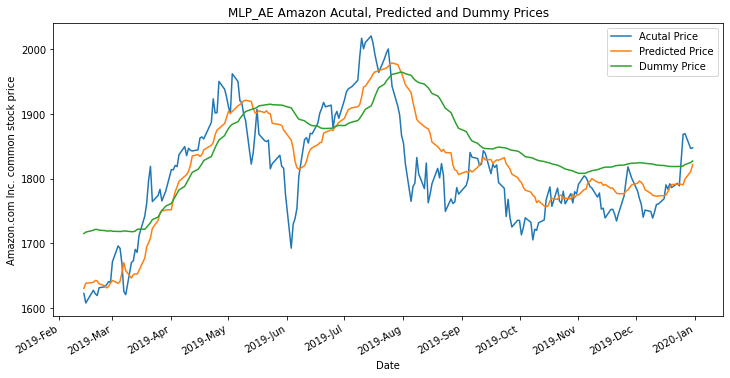

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

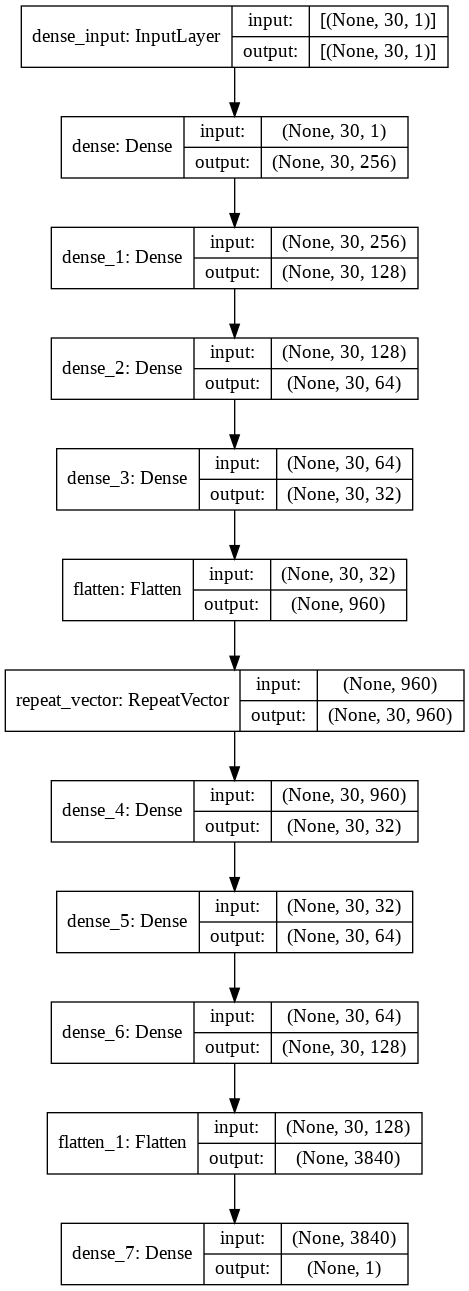

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.028118702712840806
RMSE:  0.16768632237854347
MAE:  0.13725294806550636
Dummy MSE:  0.03412892153519778
Dummy RMSE:  0.18474014597590255
Dummy MAE:  0.1546333417475681


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Amazon/assets
